In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # For splitting LSTM data
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler # For LSTM
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb
import torch
import torch.nn as nn
import torch.utils.data 
import torch.optim as optim
import pickle
import os
from matplotlib import pyplot as plt



### GSPC + Random Forest

In [8]:
sp500_path = r'D:\H.U.S.T\Machine Learning\MLOps - Remastered\data\gspc_processed_data.csv'
df_trad_processed = pd.read_csv(sp500_path, index_col='Date', parse_dates=True)
INPUT_FEATURES = [f'{'Close'}_lag_{i}' for i in range(1, 14 + 1)] + \
                 [f'{'Close'}_pct_change_1d']
TARGET_COLUMN = 'Close'
df_trad_processed['target_pct_change'] = (df_trad_processed['model_target'] - df_trad_processed['Close']) / df_trad_processed['Close']

In [9]:
df_trad_processed

,Close,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,Close_lag_8,Close_lag_9,Close_lag_10,Close_lag_11,Close_lag_12,Close_lag_13,Close_lag_14,Close_pct_change_1d,model_target,target_pct_change
Date,,,,,,,,,,,,,,,,,,
2000-01-24,1401.530029,1441.359985,1445.569946,1455.900024,1455.140015,1465.150024,1449.680054,1432.250000,1438.560059,1457.599976,1441.469971,1403.449951,1402.109985,1399.420044,1455.219971,-0.002912,1410.030029,0.006065
2000-01-25,1410.030029,1401.530029,1441.359985,1445.569946,1455.900024,1455.140015,1465.150024,1449.680054,1432.250000,1438.560059,1457.599976,1441.469971,1403.449951,1402.109985,1399.420044,-0.027634,1404.089966,-0.004213
2000-01-26,1404.089966,1410.030029,1401.530029,1441.359985,1445.569946,1455.900024,1455.140015,1465.150024,1449.680054,1432.250000,1438.560059,1457.599976,1441.469971,1403.449951,1402.109985,0.006065,1398.560059,-0.003938
2000-01-27,1398.560059,1404.089966,1410.030029,1401.530029,1441.359985,1445.569946,1455.900024,1455.140015,1465.150024,1449.680054,1432.250000,1438.560059,1457.599976,1441.469971,1403.449951,-0.004213,1360.160034,-0.027457
2000-01-28,1360.160034,1398.560059,1404.089966,1410.030029,1401.530029,1441.359985,1445.569946,1455.900024,1455.140015,1465.150024,1449.680054,1432.250000,1438.560059,1457.599976,1441.469971,-0.003938,1394.459961,0.025218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-05,5650.379883,5686.669922,5604.140137,5569.060059,5560.830078,5528.750000,5525.209961,5484.770020,5375.859863,5287.759766,5158.200195,5282.700195,5275.700195,5396.629883,5405.970215,0.014727,5606.910156,-0.007693
2025-05-06,5606.910156,5650.379883,5686.669922,5604.140137,5569.060059,5560.830078,5528.750000,5525.209961,5484.770020,5375.859863,5287.759766,5158.200195,5282.700195,5275.700195,5396.629883,-0.006382,5631.279785,0.004346
2025-05-07,5631.279785,5606.910156,5650.379883,5686.669922,5604.140137,5569.060059,5560.830078,5528.750000,5525.209961,5484.770020,5375.859863,5287.759766,5158.200195,5282.700195,5275.700195,-0.007693,5663.939941,0.005800


In [10]:

X_trad = df_trad_processed[INPUT_FEATURES].copy()
y_trad = df_trad_processed['target_pct_change'].copy()
split_idx_trad = int(len(X_trad) * 0.8)
X_train_trad, X_test_trad = X_trad.iloc[:split_idx_trad], X_trad.iloc[split_idx_trad:]
y_train_trad, y_test_trad = y_trad.iloc[:split_idx_trad], y_trad.iloc[split_idx_trad:]


In [5]:
param_grid_rf = {
        'n_estimators': [100, 150, 200,250,300,50],
        'max_depth': [10, 15, 20, 12,None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 1.0] # 1.0 for all features in regressor
    }

rf = RandomForestRegressor(random_state=42, n_jobs=-1)


In [6]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


time_series_cv = TimeSeriesSplit(n_splits=10, gap=0)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                                  cv=time_series_cv, # SỬ DỤNG TimeSeriesSplit Ở ĐÂY
                                  scoring='neg_mean_squared_error',
                                  verbose=2,
                                  n_jobs=-1)

In [7]:
grid_search_rf.fit(X_train_trad, y_train_trad)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 12, None],
                         'max_features': ['sqrt', 1.0],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200, 250, 300, 50]},
             scoring='neg_mean_squared_error', verbose=2)

In [8]:
best_params = grid_search_rf.best_params_
print(f"\nBest parameters found for RandomForest: {best_params}")
print(f"Best cross-validation score (Negative MSE with TimeSeriesSplit): {grid_search_rf.best_score_}")


Best parameters found for RandomForest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 250}
Best cross-validation score (Negative MSE with TimeSeriesSplit): -0.00016588919786753107


In [9]:
# model = RandomForestRegressor(**{'max_depth': 12, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}, random_state=42, n_jobs=-1)
model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
model.fit(X_train_trad, y_train_trad)
y_pred_pct_change_test = model.predict(X_test_trad)

In [10]:
last_actual_close_for_test_samples = df_trad_processed.loc[X_test_trad.index, TARGET_COLUMN]
y_test_absolute_actual = df_trad_processed.loc[X_test_trad.index, 'model_target']
y_pred_absolute_test = last_actual_close_for_test_samples * (1 + y_pred_pct_change_test)


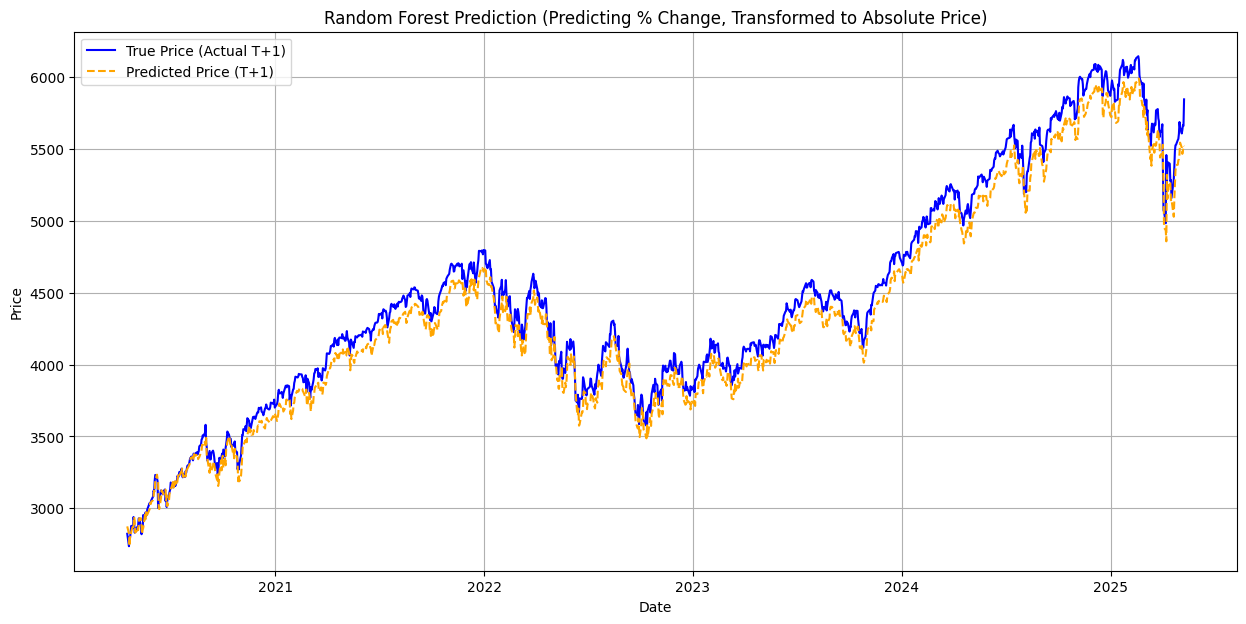

In [11]:
plt.figure(figsize=(15, 7))
plt.plot(y_test_absolute_actual.index, y_test_absolute_actual, label='True Price (Actual T+1)', color='blue')
plt.plot(y_test_absolute_actual.index, y_pred_absolute_test, label='Predicted Price (T+1)', color='orange', linestyle='--')
plt.title('Random Forest Prediction (Predicting % Change, Transformed to Absolute Price)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### GSPC + XGBoost

In [12]:
param_grid_xgb = {
        'n_estimators': [100, 150, 200, 250],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, 9],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'gamma': [0, 0.1, 0.2], # Minimum loss reduction required to make a further partition
        # 'reg_alpha': [0, 0.01, 0.1], # L1 regularization
        # 'reg_lambda': [1, 0.1, 0.01] # L2 regularization
    }

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42,
                               # early_stopping_rounds can't be directly used with scikit-learn GridSearchCV
                               # It's handled by XGBoost's fit method if eval_set is provided there.
                               # For GridSearchCV, we rely on CV scores.
                               tree_method='hist' # Often faster for larger datasets
                               )

grid_search_xgb = GridSearchCV(estimator=xgb_reg, param_grid=param_grid_xgb,
                                   cv=10,
                                   scoring='neg_mean_squared_error',
                                   verbose=2,
                                   n_jobs=-1)

In [13]:
grid_search_xgb.fit(X_train_trad, y_train_trad)

Fitting 10 folds for each of 1296 candidates, totalling 12960 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=Non...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 150, 200, 250],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_mean_squared_error', verbose=2)

In [14]:
best_params_xgb = grid_search_xgb.best_params_
print(f"\nBest parameters found for XGBoost: {best_params_xgb}")
print(f"Best cross-validation score (Negative MSE with TimeSeriesSplit): {grid_search_xgb.best_score_}")


Best parameters found for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.7}
Best cross-validation score (Negative MSE with TimeSeriesSplit): -0.000156698899346098


In [15]:
model = xgb.XGBRegressor(**best_params_xgb, objective='reg:squarederror', random_state=42,
                               tree_method='hist')
model.fit(X_train_trad, y_train_trad)
y_pred = model.predict(X_test_xgb)

In [16]:
last_actual_close_for_test_samples = df_trad_processed.loc[X_test_trad.index, TARGET_COLUMN]
y_test_absolute_actual = df_trad_processed.loc[X_test_trad.index, 'model_target']
y_pred_absolute_test = last_actual_close_for_test_samples * (1 + y_pred)

In [17]:
y_pred_absolute_test

Date
2020-04-17    2875.251575
2020-04-20    2823.839064
2020-04-21    2737.218377
2020-04-22    2799.983473
2020-04-23    2798.473100
                 ...     
2025-05-05    5651.739163
2025-05-06    5608.258979
2025-05-07    5632.634470
2025-05-08    5665.302483
2025-05-09    5661.271729
Name: Close, Length: 1273, dtype: float64

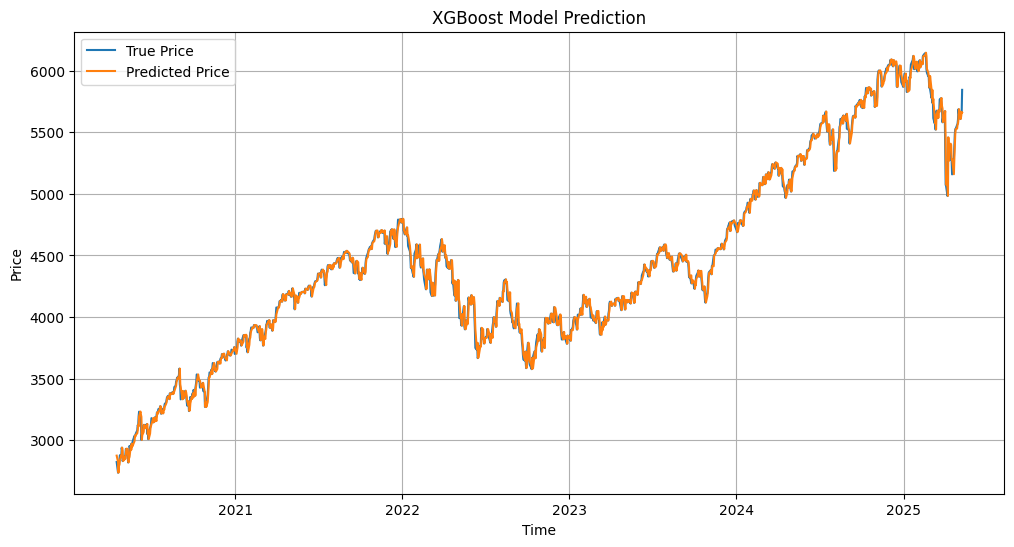

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_absolute_actual, label='True Price')
plt.plot(y_pred_absolute_test, label='Predicted Price')
plt.title('XGBoost Model Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### IBM + Random Forest

In [19]:
sp500_path = r'D:\H.U.S.T\Machine Learning\MLOps - Remastered\data\ibm_processed_data.csv'
df_trad_processed = pd.read_csv(sp500_path, index_col='Date', parse_dates=True)
INPUT_FEATURES = [f'{'Close'}_lag_{i}' for i in range(1, 14 + 1)] + \
                 [f'{'Close'}_pct_change_1d']
TARGET_COLUMN = 'Close'
df_trad_processed['target_pct_change'] = (df_trad_processed['model_target'] - df_trad_processed['Close']) / df_trad_processed['Close']

In [20]:

X_trad = df_trad_processed[INPUT_FEATURES].copy()
y_trad = df_trad_processed['target_pct_change'].copy()
split_idx_trad = int(len(X_trad) * 0.8)
X_train_trad, X_test_trad = X_trad.iloc[:split_idx_trad], X_trad.iloc[split_idx_trad:]
y_train_trad, y_test_trad = y_trad.iloc[:split_idx_trad], y_trad.iloc[split_idx_trad:]


In [21]:
param_grid_rf = {
        'n_estimators': [100, 150, 200,250,300,50],
        'max_depth': [10, 15, 20, 12,None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 1.0] # 1.0 for all features in regressor
    }

rf = RandomForestRegressor(random_state=42, n_jobs=-1)


In [22]:
time_series_cv = TimeSeriesSplit(n_splits=10, gap=0)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                                  cv=time_series_cv, # SỬ DỤNG TimeSeriesSplit Ở ĐÂY
                                  scoring='neg_mean_squared_error',
                                  verbose=2,
                                  n_jobs=-1)

In [23]:
grid_search_rf.fit(X_train_trad, y_train_trad)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 12, None],
                         'max_features': ['sqrt', 1.0],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200, 250, 300, 50]},
             scoring='neg_mean_squared_error', verbose=2)

In [24]:
best_params = grid_search_rf.best_params_
print(f"\nBest parameters found for RandomForest: {best_params}")
print(f"Best cross-validation score (Negative MSE with TimeSeriesSplit): {grid_search_rf.best_score_}")
# model = RandomForestRegressor(**{'max_depth': 12, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}, random_state=42, n_jobs=-1)
model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
model.fit(X_train_trad, y_train_trad)
y_pred_pct_change_test = model.predict(X_test_trad)
last_actual_close_for_test_samples = df_trad_processed.loc[X_test_trad.index, TARGET_COLUMN]
y_test_absolute_actual = df_trad_processed.loc[X_test_trad.index, 'model_target']
y_pred_absolute_test = last_actual_close_for_test_samples * (1 + y_pred_pct_change_test)



Best parameters found for RandomForest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation score (Negative MSE with TimeSeriesSplit): -0.0002649294649130842


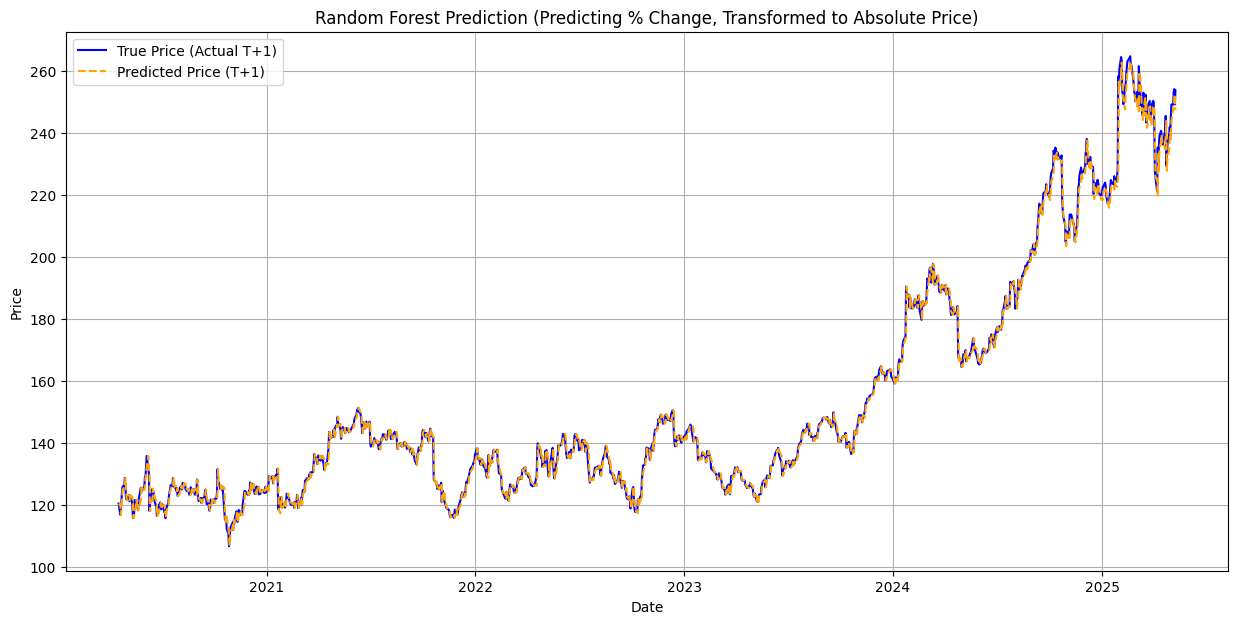

In [25]:
plt.figure(figsize=(15, 7))
plt.plot(y_test_absolute_actual.index, y_test_absolute_actual, label='True Price (Actual T+1)', color='blue')
plt.plot(y_test_absolute_actual.index, y_pred_absolute_test, label='Predicted Price (T+1)', color='orange', linestyle='--')
plt.title('Random Forest Prediction (Predicting % Change, Transformed to Absolute Price)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### IBM + XGBoost

In [26]:
param_grid_xgb = {
        'n_estimators': [100, 150, 200, 250],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, 9],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'gamma': [0, 0.1, 0.2], # Minimum loss reduction required to make a further partition
        # 'reg_alpha': [0, 0.01, 0.1], # L1 regularization
        # 'reg_lambda': [1, 0.1, 0.01] # L2 regularization
    }

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42,
                               # early_stopping_rounds can't be directly used with scikit-learn GridSearchCV
                               # It's handled by XGBoost's fit method if eval_set is provided there.
                               # For GridSearchCV, we rely on CV scores.
                               tree_method='hist' # Often faster for larger datasets
                               )

grid_search_xgb = GridSearchCV(estimator=xgb_reg, param_grid=param_grid_xgb,
                                   cv=10,
                                   scoring='neg_mean_squared_error',
                                   verbose=2,
                                   n_jobs=-1)

In [27]:
grid_search_xgb.fit(X_train_trad, y_train_trad)

Fitting 10 folds for each of 1296 candidates, totalling 12960 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=Non...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 150, 200, 250],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_mean_squared_error', verbose=2)

In [28]:
best_params_xgb = grid_search_xgb.best_params_
print(f"\nBest parameters found for XGBoost: {best_params_xgb}")
print(f"Best cross-validation score (Negative MSE with TimeSeriesSplit): {grid_search_xgb.best_score_}")


Best parameters found for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Best cross-validation score (Negative MSE with TimeSeriesSplit): -0.00027704233790997216


In [29]:
model = xgb.XGBRegressor(**best_params_xgb, objective='reg:squarederror', random_state=42,
                               tree_method='hist')
model.fit(X_train_trad, y_train_trad)
y_pred = model.predict(X_test_xgb)
last_actual_close_for_test_samples = df_trad_processed.loc[X_test_trad.index, TARGET_COLUMN]
y_test_absolute_actual = df_trad_processed.loc[X_test_trad.index, 'model_target']
y_pred_absolute_test = last_actual_close_for_test_samples * (1 + y_pred)

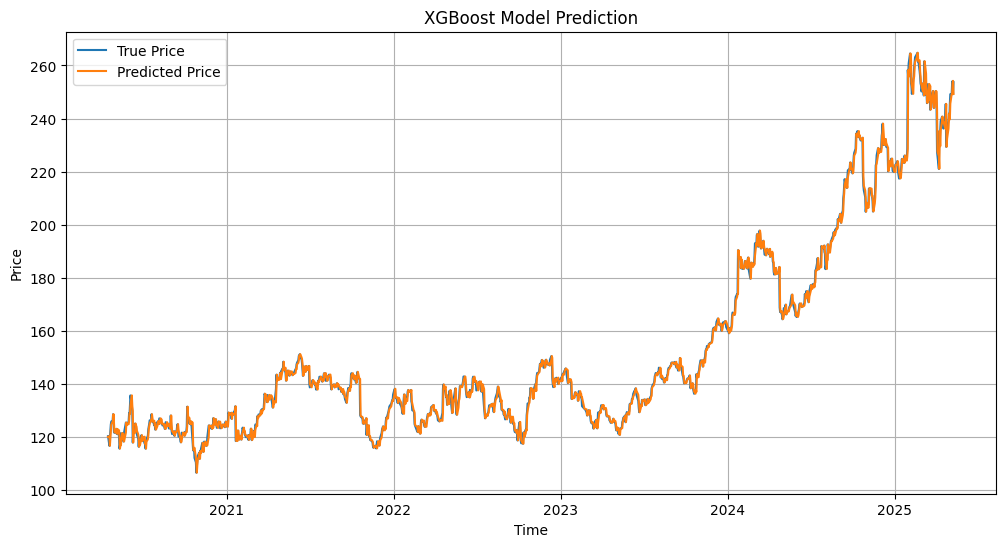

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_absolute_actual, label='True Price')
plt.plot(y_pred_absolute_test, label='Predicted Price')
plt.title('XGBoost Model Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
y_pred_absolute_test

Date
2020-04-17    120.137684
2020-04-20    120.427727
2020-04-21    116.777190
2020-04-22    119.327565
2020-04-23    121.367866
                 ...    
2025-05-05    249.216685
2025-05-06    249.156676
2025-05-07    253.407302
2025-05-08    254.177415
2025-05-09    249.236688
Name: Close, Length: 1273, dtype: float64

In [32]:
y_test_absolute_actual

Date
2020-04-17    120.41
2020-04-20    116.76
2020-04-21    119.31
2020-04-22    121.35
2020-04-23    124.72
               ...  
2025-05-05    249.12
2025-05-06    253.37
2025-05-07    254.14
2025-05-08    249.20
2025-05-09    253.69
Name: model_target, Length: 1273, dtype: float64

In [37]:
y_pred

array([0.00014724, 0.00014724, 0.00014724, ..., 0.00014724, 0.00014724,
       0.00014724], shape=(1273,), dtype=float32)

In [35]:
y_pred_series = pd.Series(y_pred, index=y_test_trad.index)

In [36]:
y_test_trad, y_pred_series

(Date
 2020-04-17    0.002414
 2020-04-20   -0.030313
 2020-04-21    0.021840
 2020-04-22    0.017098
 2020-04-23    0.027771
                 ...   
 2025-05-05   -0.000241
 2025-05-06    0.017060
 2025-05-07    0.003039
 2025-05-08   -0.019438
 2025-05-09    0.018018
 Name: target_pct_change, Length: 1273, dtype: float64,
 Date
 2020-04-17    0.000147
 2020-04-20    0.000147
 2020-04-21    0.000147
 2020-04-22    0.000147
 2020-04-23    0.000147
                 ...   
 2025-05-05    0.000147
 2025-05-06    0.000147
 2025-05-07    0.000147
 2025-05-08    0.000147
 2025-05-09    0.000147
 Length: 1273, dtype: float32)